### Importing Relevant Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import chi2_contingency

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from math import radians, sin, cos, sqrt, atan2


## Data Cleaning

In [2]:
# importing data
data = pd.read_csv('full.csv')

In [3]:
# counting the initial number rows and columns
initial_rows = data.shape[0]
initial_columns = data.shape[1]

print(f'Number of initial rows: {initial_rows}')
print(f'Number of initial columns: {initial_columns}')

Number of initial rows: 45593
Number of initial columns: 20


In [4]:
# checking the number of nulls
data.isnull().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64

In [5]:
# checking for actual nulls
data['multiple_deliveries'].value_counts()

multiple_deliveries
1       28159
0       14095
2        1985
NaN       993
3         361
Name: count, dtype: int64

There are null values but they are indicated as the string "NaN "

In [6]:
# replace all NaN strings with actual nulls
data.replace('NaN ', np.nan, inplace = True)

In [7]:
# checking for nulls again
data.isnull().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions                 0
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

In [8]:
# dropping all nulls
data = data.dropna()

In [9]:
# checking the data types of each column
data.dtypes

ID                              object
Delivery_person_ID              object
Delivery_person_Age             object
Delivery_person_Ratings         object
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Order_Date                      object
Time_Orderd                     object
Time_Order_picked               object
Weatherconditions               object
Road_traffic_density            object
Vehicle_condition                int64
Type_of_order                   object
Type_of_vehicle                 object
multiple_deliveries             object
Festival                        object
City                            object
Time_taken(min)                 object
dtype: object

In [10]:
# changing the data type of Delivery_person_Age and Delivery_person_Ratings
data['Delivery_person_Age'] = data['Delivery_person_Age'].astype('float64')
data['Delivery_person_Ratings'] = data['Delivery_person_Ratings'].astype('float64')


In [11]:
# converting Order_Date into datetime
data['Order_Date'] = pd.to_datetime(data['Order_Date'], format='%d-%m-%Y')

# converting Time_Orderd and Time_Order_picked into time
data['Time_Orderd'] = pd.to_datetime(data['Time_Orderd'], format='%H:%M:%S')
data['Time_Orderd_hour'] = data['Time_Orderd'].dt.hour

data['Time_Order_picked'] = pd.to_datetime(data['Time_Order_picked'], format='%H:%M:%S')
data['Time_Order_picked_hour'] = data['Time_Order_picked'].dt.hour

In [12]:
# classifying Time_Orderd and Time_Order_picked into Morning, Afternoon and Evening
data['Time_of_Day_Orderd'] = pd.cut(data['Time_Orderd_hour'], bins=[0, 12, 18, 24], labels=['Morning', 'Afternoon', 'Evening'])
data['Time_of_Day_picked'] = pd.cut(data['Time_Order_picked_hour'], bins=[0, 12, 18, 24], labels=['Morning', 'Afternoon', 'Evening'])

# changing to object data type
data['Time_of_Day_Orderd'] = data['Time_of_Day_Orderd'].astype('object')
data['Time_of_Day_picked'] = data['Time_of_Day_picked'].astype('object')


In [13]:
# drop the unneccesary columns
data = data.drop(['Order_Date', 'Time_Orderd', 'Time_Orderd_hour', 'Time_Order_picked', 'Time_Order_picked_hour'], axis = 1)

# drop any nulls
data = data.dropna()

### Getting Distance Betweeen Restaurant and Delivery Location using Latitude and Longitude data

In [14]:
# defining a function to caluclate distance between 2 points using Lat and Long data
# using haversine formula
# distance is in km

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the earth in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return round(distance, 5)

In [15]:
# using the function to calculate the distance
data['Distance'] = data.apply(lambda row: haversine(row['Restaurant_latitude'], row['Restaurant_longitude'], row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)

### Using KMeans Clustering Algorithm to cluster latitude and longitude together

In [16]:
restaurant = data[['Restaurant_latitude', 'Restaurant_longitude']]
delivery = data[['Delivery_location_latitude', 'Delivery_location_longitude']]

In [17]:
# specifying my own clusters
# each lat and long pair will be classified as North, South, East, West
# each lat and long pairs are in the center of the region

cluster_centers = np.array([[29.400000, 77.200000], [11.100000, 78.700000], [22.800000, 86.100000], [21.200000, 72.800000]])

In [18]:
kmeans_delivery = KMeans(n_clusters = 4, init = cluster_centers, n_init = 1, max_iter = 500, random_state = 42).fit(delivery)
kmeans_restaurant = KMeans(n_clusters = 4, init = cluster_centers, n_init = 1, max_iter = 500, random_state = 42).fit(restaurant)

data['Delivery_Cluster'] = kmeans_delivery.labels_
data['Restaurant_Cluster'] = kmeans_restaurant.labels_

# changing data type
data['Delivery_Cluster'] = data['Delivery_Cluster'].astype('object')
data['Restaurant_Cluster'] = data['Restaurant_Cluster'].astype('object')

In [19]:
# mapping the clusters into North, South, East, West
location_map = {0: 'North', 1: 'South', 2: 'East', 3: 'West'}

# apply the mapping to the column
data['Delivery_Cluster'] = data['Delivery_Cluster'].map(location_map)
data['Restaurant_Cluster'] = data['Restaurant_Cluster'].map(location_map)

In [20]:
# extracting only weather conditions from Weatherconditions
words = data['Weatherconditions'].str.split()
conditions = words.str[1] 

data['Weatherconditions'] = conditions

In [21]:
# extracting only the mins value from time taken column
words_ = data['Time_taken(min)'].str.split()
time_taken = words_.str[1]

data['Time_taken_mins'] = time_taken
data['Time_taken_mins'] = data['Time_taken_mins'].astype('float64')

In [22]:
# mapping vehicle condition to its conditions
condition_map = {0: 'Below Average', 1: 'Average', 2: 'Good'}

# Apply the mapping to the column
data['Vehicle_condition'] = data['Vehicle_condition'].map(condition_map)

In [23]:
# dropping unneccesary columns
"""
Reasons for dropping columns:
(1) index, ID and Delivery_person_ID is not needed in the model
(2) Restaurant and Delivery Location Lat and Long data is used to calculate distance 
(3) Time_taken (min) is replaced my Time_taken_mins
(4) Restaurant cluster and Delivery location cluster mostly are the same in the dataset (excluding outliers)
(5) Time_of_Day_picked is mostly the same as Time_of_Day_orderd
(6) Festival and City do not have much meaning in this dataset 
(7) Multiple deliveries is slightly confusing

"""
data = data.reset_index().drop(['index', 'ID', 'Delivery_person_ID', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Time_taken(min)', 'Restaurant_Cluster', 'Time_of_Day_picked', 'Festival', 'City', 'multiple_deliveries'], axis = 1)

In [24]:
# changing delivery ratings to satisfaction_percentage
data['Delivery_person_Ratings'] = (data['Delivery_person_Ratings']/5) * 100

In [25]:
# rename Delivery_person_Ratings to Satisfaction_Perc and Delivery_Cluster to Region
data = data.rename(columns={'Delivery_person_Ratings': 'Satisfaction_Perc', 'Delivery_Cluster': 'Region'})

In [26]:
# checking end number of rows and columns
end_rows = data.shape[0]
end_columns = data.shape[1]

print(f'Number of final rows: {end_rows}')
print(f'Number of final columns: {end_columns}')

Number of final rows: 40197
Number of final columns: 11


## Explaratory Data Analysis

In [31]:
data.dtypes

Delivery_person_Age     float64
Satisfaction_Perc       float64
Weatherconditions        object
Road_traffic_density     object
Vehicle_condition        object
Type_of_order            object
Type_of_vehicle          object
Time_of_Day_Orderd       object
Distance                float64
Region                   object
Time_taken_mins         float64
dtype: object

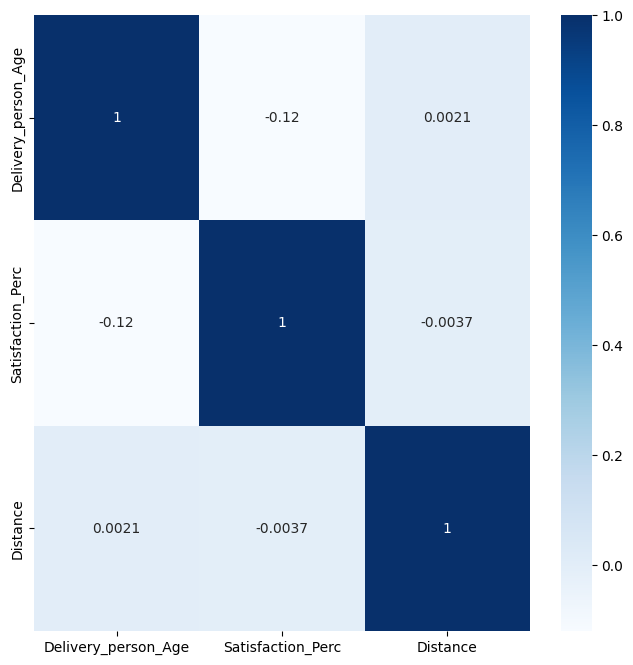

In [32]:
# plotting the correlation matrix to explore relationships between numerical variables
# select the numerical columns
numeric = data[['Delivery_person_Age', 'Satisfaction_Perc', 'Distance']]

# scaling data for easier comparison
scaler = StandardScaler()
numeric = scaler.fit_transform(numeric)

# convert the scaled numerical columns back to a pandas DataFrame
numeric = pd.DataFrame(numeric, columns=['Delivery_person_Age', 'Satisfaction_Perc', 'Distance'])

# plot heat map
plt.figure(figsize = (8,8))
sns.heatmap(numeric.corr(), cbar = True, annot = True, cmap = 'Blues')
plt.show()

In [33]:
cat_var = data[['Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'Time_of_Day_Orderd', 'Region']]

# create a list of variable pairs
variable_pairs = [(x, y) for i, x in enumerate(cat_var.columns) for j, y in enumerate(cat_var.columns) if i < j]

# create empty lists for independent and dependent variables
independent_vars = []
dependent_vars = []

# loop through each variable pair
for pair in variable_pairs:
    # create a contingency table
    contingency_table = pd.crosstab(cat_var[pair[0]], cat_var[pair[1]])
    
    # calculate the chi-squared test statistic, p-value, degrees of freedom, and expected table
    chi2_stat, p_val, dof, expected_table = chi2_contingency(contingency_table)
    
    # compare the obtained p-value with the significance level of 0.05
    if p_val <= 0.05:
        dependent_vars.append(pair)
    else:
        independent_vars.append(pair)

# calculate Cramér's V for dependent variable pairs
# Cramér's V calculates the association between 2 categorical variables

for pair in dependent_vars:
    contingency_table = pd.crosstab(cat_var[pair[0]], cat_var[pair[1]])
    chi2_stat, p_val, dof, expected_table = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2_stat / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    print(f"Cramér's V for {pair[0]} and {pair[1]}: {cramers_v}")

Cramér's V for Road_traffic_density and Time_of_Day_Orderd: 0.7742651711977193
Cramér's V for Vehicle_condition and Type_of_vehicle: 0.4979389093381019
Cramér's V for Type_of_vehicle and Region: 0.01050935699748268


In [34]:
nominal_variables = ['Weatherconditions', 'Type_of_Order', 'Type_of_vehicle', 'Region']
ordinal_variables = ['Road_traffic_density', 'Vehicle_condition', 'Time_of_Day_Orderd']

